In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder ,StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

In [11]:
df = pd.read_csv("features/emotion_features.csv")
df.head()


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,label
0,-592.51970,55.269863,-19.240614,14.985034,-4.303793,-0.782968,-15.683035,-4.746463,-22.302803,-5.347614,...,-6.584931,-2.434462,-3.743652,-0.299833,1.267962,5.327147,3.982636,8.654726,11.515517,neutral
1,-571.77120,53.821240,-19.770304,14.672212,-3.221300,-2.219379,-15.660700,-4.115021,-21.762812,-0.923149,...,-6.433335,-2.461543,-4.143042,0.553830,1.998689,5.020371,4.224607,9.785756,11.845788,neutral
2,-579.21670,54.232810,-15.242693,17.250660,-4.751228,0.021345,-13.251750,-5.477705,-20.139534,-4.198607,...,-5.051621,-1.963996,-3.542640,-0.745385,1.221582,3.439566,5.602417,9.031712,9.748875,neutral
3,-581.09064,53.249720,-19.030127,17.035284,-5.648746,1.875090,-16.216503,-5.108720,-21.046432,-2.953222,...,-5.261818,-2.072452,-4.843049,0.880779,1.297034,4.160462,5.900162,9.407315,10.992938,neutral
4,-592.52057,61.175182,-16.242025,16.972326,-1.740968,-0.389398,-15.755614,-1.111939,-19.680891,-3.488038,...,2.623967,3.312066,-4.676119,-4.766972,-4.045164,1.991833,5.520200,10.280448,11.302134,calm


In [12]:
X = df.drop("label", axis=1)
y = df["label"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))

Training samples: 1961
Validation samples: 491


In [13]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model trained!")

Model trained!


In [14]:
y_pred = model.predict(X_val)

# Overall Accuracy & F1
overall_accuracy = accuracy_score(y_val, y_pred)
overall_f1 = f1_score(y_val, y_pred, average='weighted')

print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
print(f"Weighted F1 Score: {overall_f1 * 100:.2f}%")

Overall Accuracy: 71.28%
Weighted F1 Score: 70.94%


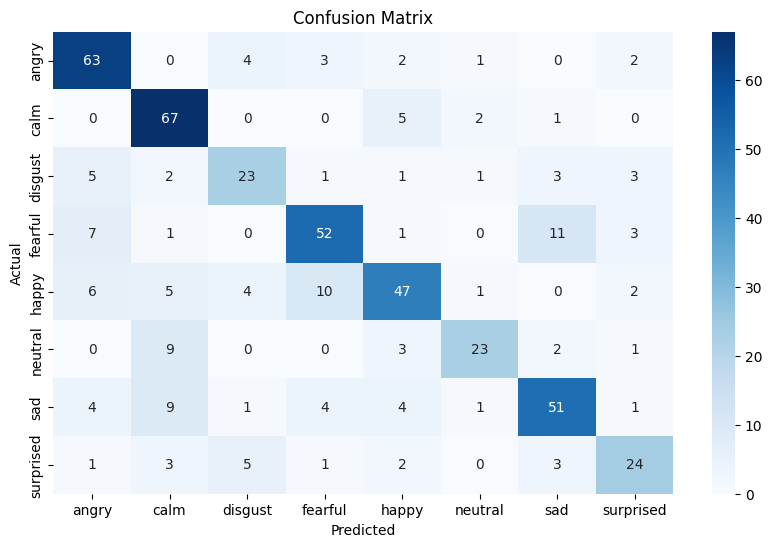

In [17]:
cm = confusion_matrix(y_val, y_pred, labels=model.classes_)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [18]:
report = classification_report(y_val, y_pred, output_dict=True)

print("Per-Class Accuracies:")
for label in model.classes_:
    class_acc = report[label]["recall"] * 100
    print(f"{label}: {class_acc:.2f}% accuracy")

Per-Class Accuracies:
angry: 84.00% accuracy
calm: 89.33% accuracy
disgust: 58.97% accuracy
fearful: 69.33% accuracy
happy: 62.67% accuracy
neutral: 60.53% accuracy
sad: 68.00% accuracy
surprised: 61.54% accuracy


In [21]:

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

In [22]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train_enc)

y_pred_enc = xgb_model.predict(X_val)

C:\Users\viren\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:28:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [23]:
y_pred = le.inverse_transform(y_pred_enc)


XGBoost Accuracy: 73.52 %
XGBoost F1 Score: 73.14 %
Per-Class Accuracies:
  angry: 88.00%
  calm: 93.33%
  disgust: 58.97%
  fearful: 70.67%
  happy: 69.33%
  neutral: 68.42%
  sad: 62.67%
  surprised: 61.54%


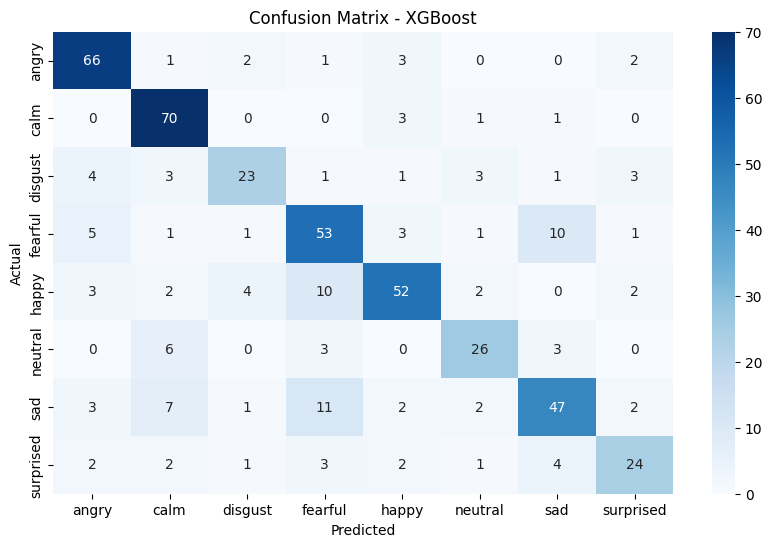

In [26]:
# Accuracy & F1
print("XGBoost Accuracy:", round(accuracy_score(y_val, y_pred) * 100, 2), "%")
print("XGBoost F1 Score:", round(f1_score(y_val, y_pred, average='weighted') * 100, 2), "%")

# Per-Class Accuracy
report = classification_report(y_val, y_pred, output_dict=True)
print("Per-Class Accuracies:")
for label in xgb_model.classes_:
    print(f"  {le.inverse_transform([label])[0]}: {report[le.inverse_transform([label])[0]]['recall']*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred, labels=le.classes_)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [28]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train_enc)

y_pred_enc = gb_model.predict(X_val)
y_pred = le.inverse_transform(y_pred_enc)

GB Accuracy: 61.3 %
GB F1 Score: 60.65 %
Per-Class Accuracies:
  angry: 77.33%
  calm: 82.67%
  disgust: 25.64%
  fearful: 61.33%
  happy: 53.33%
  neutral: 50.00%
  sad: 56.00%
  surprised: 61.54%


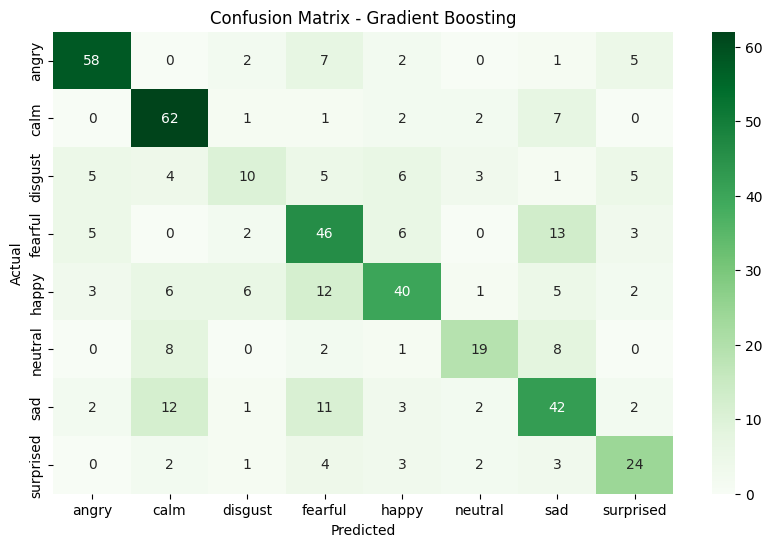

In [29]:
print("GB Accuracy:", round(accuracy_score(y_val, y_pred) * 100, 2), "%")
print("GB F1 Score:", round(f1_score(y_val, y_pred, average='weighted') * 100, 2), "%")

report = classification_report(y_val, y_pred, output_dict=True)
print("Per-Class Accuracies:")
for label in gb_model.classes_:
    print(f"  {le.inverse_transform([label])[0]}: {report[le.inverse_transform([label])[0]]['recall']*100:.2f}%")

cm = confusion_matrix(y_val, y_pred, labels=le.classes_)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()

In [31]:
# Create a pipeline with scaling + SVM
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True, random_state=42))

# Train
svm_model.fit(X_train, y_train_enc)

# Predict
y_pred_enc = svm_model.predict(X_val)
y_pred = le.inverse_transform(y_pred_enc)

SVM Accuracy: 67.62 %
SVM F1 Score: 67.2 %
Per-Class Accuracies:
  angry: 85.33%
  calm: 86.67%
  disgust: 53.85%
  fearful: 73.33%
  happy: 53.33%
  neutral: 50.00%
  sad: 56.00%
  surprised: 66.67%


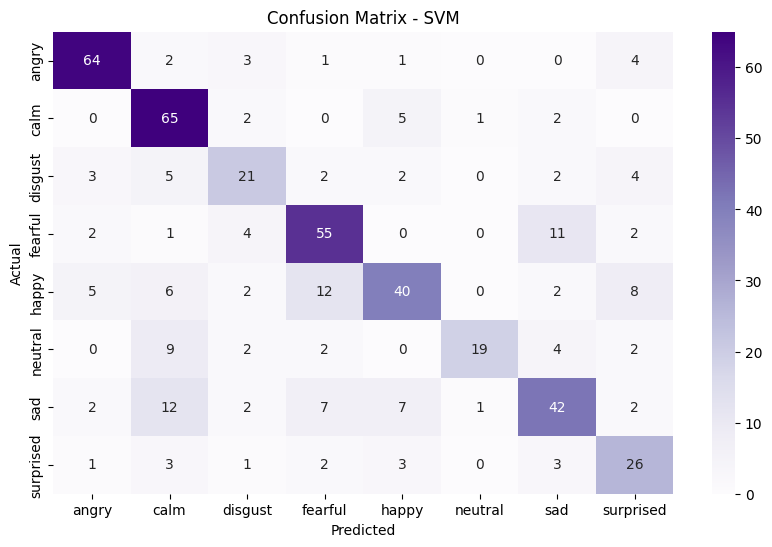

In [32]:
print("SVM Accuracy:", round(accuracy_score(y_val, y_pred) * 100, 2), "%")
print("SVM F1 Score:", round(f1_score(y_val, y_pred, average='weighted') * 100, 2), "%")

report = classification_report(y_val, y_pred, output_dict=True)
print("Per-Class Accuracies:")
for label in le.classes_:
    recall = report[label]["recall"] * 100
    print(f"  {label}: {recall:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred, labels=le.classes_)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Purples")
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
